<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/InpaintingMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

In [0]:
generator_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path     = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path    = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
plot_path        = './gdrive/My Drive/MPM/modules/gauss3b/plots/'

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
data_dim    = 28*28
data_size   = 1
sigma_n     = 0.12
hidden_size = 10
n_channels  = 1
num_comp    = 2
corr_type   = 'sparse mask'
num_mnist   = 1#6
label       = 'sparse95'
seed        = 777

In [0]:
def plot_image(image, save=True, directory='./plots/',filename='plotted_image', title='image',vmin=None,vmax=None, mask=None):
  
  if np.any(mask==None):
    mask=np.ones_like(image)
  mask = np.reshape(mask,(28,28))
  plt.figure()
  plt.title(title)
  plt.imshow((image).reshape((28,28))*mask,cmap='gray',vmin=vmin, vmax=vmax)
  plt.axis('off')
  plt.colorbar()
  if save: 
    plt.savefig(directory+filename+'.png',bbox_inches='tight')
  plt.show()
  
  return True

def get_custom_noise(shape, signal_dependent=False, signal =None, sigma_low=0.07, sigma_high=0.22, threshold=0.02 ):
  
  sigma = np.ones(shape)*sigma_n
  
  if signal_dependent: 
    for ii in range(data_size):
      sigma[ii][np.where(signal[ii]<=threshold)]= sigma_low
      sigma[ii][np.where(signal[ii]>threshold)]= sigma_high
  
  return sigma
  

def make_corrupted_data(x_true, corr_type='mask'):
  
  mask = np.ones((28,28))
  
  if corr_type=='mask':
    
    minx = 10
    maxx = 24
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28*28))
    
    corr_data = x_true*[mask]
    
  elif corr_type=='sparse mask':
    
    
    mask    = np.ones(data_dim, dtype=int)
    percent = 95
    np.random.seed(seed+2)
    indices = np.random.choice(np.arange(data_dim), replace=False,size=int(percent/100.*data_dim))
    print(len(indices)/data_dim)
    mask[indices] =0 
  
    corr_data = x_true*[mask]
    
  elif corr_type=='none':
    
    corr_data = x_true
    
  corr_data = np.expand_dims(corr_data,-1)
  
  return corr_data, mask

In [0]:
def fwd_pass(generator,nvp,z,mask):
  
  fwd_z           = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z},as_dict=True)['fwd_pass']

  gen_z           = tf.boolean_mask(tf.reshape(generator(fwd_z),[data_size,data_dim,n_channels]),mask, axis=1)

  return gen_z


def get_likelihood(generator,nvp,z,sigma,mask):
  
  gen_z           = fwd_pass(generator,nvp,z,mask)
  
  sigma           = tf.boolean_mask(sigma,mask, axis=1)

  likelihood      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma))

  return likelihood

def get_prior():
  
  return tfd.MultivariateNormalDiag(tf.zeros([data_size,hidden_size]), scale_identity_multiplier=1.0, name ='prior')

def get_log_posterior(z,x,generator,nvp,sigma,mask, beta):

  likelihood      = get_likelihood(generator,nvp,z,sigma,mask)
  
  prior           = get_prior()
  
  masked_x        = tf.boolean_mask(x,mask, axis=1)
  
  log_posterior   = prior.log_prob(z)+likelihood.log_prob(masked_x)*beta
  
  return log_posterior


def get_recon(generator,nvp, z,sigma,mask):
  
  prob = get_likelihood(generator,nvp, z,sigma,mask)
  
  recon= prob.mean()
  
  return recon

def get_hessian(func, z):
  
  hess             = tf.hessians(func,z)
  hess             = tf.gather(hess, 0)
  
  return(tf.reduce_sum(hess, axis = 2 ))


def get_GN_hessian(generator,nvp,z,mask,sigma):


  gen_z            = fwd_pass(generator,nvp,z,mask)
  
  sigma            = tf.boolean_mask(sigma,mask, axis=1)

  grad_g           = tf.gather(tf.gradients(gen_z/(sigma),z),0)

  grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

  one              = tf.linalg.eye(hidden_size, batch_shape=[data_size],dtype=tf.float32)

  hess_GN          = one+grad_g2
  
  return hess_GN
  
def compute_covariance(hessian):
  
  cov = tf.linalg.inv(hessian)
  
  cov = (cov+tf.linalg.transpose(cov))*0.5
  
  return cov

In [0]:
def minimize_posterior(initial_value, x, custom_mask, noise, my_sess, annealing =True):
  
  ini = np.reshape(initial_value,[data_size,hidden_size])
  
  my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:ini, mask:custom_mask,sigma_corr:noise})
  
  pos_def = False

  
  posterior_loss = []
  for lrate, numiter in zip([1e-1,1e-2,1e-3],[10000,5000,3000]):
    print('lrate', lrate)
    for jj in range(numiter):
      if annealing and lrate==1e-1:
        inv_T= np.round(0.5*np.exp(-(1.-jj/numiter)),decimals=1)
      else:
        inv_T= 1.
      _, ll = my_sess.run([opt_op_MAP,loss_MAP],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate, inverse_T:inv_T})
      posterior_loss.append(ll)
      if jj%1000==0:
        print('iter', jj, 'loss', ll,r'inverse T', inv_T)
        
  z_value = my_sess.run(MAP,feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise})
  
  eig     = my_sess.run(tf.linalg.eigvalsh(hessian),feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  if np.all(eig>0.):
    pos_def = True
  
  loss    = ll
  plt.figure()
  plt.plot(posterior_loss)
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.show()
  
  return z_value, loss, pos_def
  

In [0]:
def get_laplace_sample(num,map_value,x,mymask,noise,my_sess):
  
  my_sess.run(MAP_reset,feed_dict={MAP_ini:map_value})
  my_sess.run(update_mu)
  my_sess.run(update_TriL,feed_dict={input_data: x, mask: mymask, sigma_corr:noise})
  
  samples=[]
  for ii in range(num):
    my_sess.run(posterior_sample,feed_dict={input_data: x, sigma_corr:noise})
    samples.append(my_sess.run(recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

In [0]:
def plot_samples(samples, mask, title='samples', filename='samples'):
  plt.figure()
  plt.title(title)
  for i in range(min(len(samples),16)):
      subplot(4,4,i+1)
      imshow(np.reshape(samples[i,:],(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
      axis('off')
  plt.colorbar()  
  plt.savefig(plot_path+filename+'.png',bbox_inches='tight')
  plt.show()
  

  plt.figure()
  plt.title('masked'+title)
  for i in range(min(len(samples),16)):
      subplot(4,4,i+1)
      imshow(np.reshape(samples[i,0,:,0]*mask,(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
      axis('off')
  plt.colorbar()      
  plt.savefig(plot_path+filename+'masked.png',bbox_inches='tight')
  plt.show()

In [0]:
def get_random_start_values(num, my_sess):
  result=[]
  for ii in range(num):
    result.append(my_sess.run(get_prior().sample()))
  return result

In [0]:
def get_chi2(sigma,data,mean,masking=True, mask=None):
  
  if masking:
    mask = np.reshape(mask,data.shape)
    data = data[np.where(mask==1)]
    mean = mean[np.where(mask==1)]
    sigma= sigma[np.where(mask==1)]
    
  
  low = min(sigma.flatten())
  high= max(sigma.flatten())
  
  chi2_tot = np.sum((data-mean)**2/sigma**2)
  dof_tot  = len(np.squeeze(data))
  chi2_low = np.sum((data[np.where(sigma==low)]-mean[np.where(sigma==low)])**2/sigma[np.where(sigma==low)]**2)
  dof_low  = len(np.squeeze(data[np.where(sigma==low)]))
  chi2_high= np.sum((data[np.where(sigma==high)]-mean[np.where(sigma==high)])**2/sigma[np.where(sigma==high)]**2)
  dof_high = len(np.squeeze(data[np.where(sigma==high)]))
  
  return chi2_tot, dof_tot, chi2_low, dof_low, chi2_high, dof_high, masking

In [0]:
def plot_minima(minima, losses, var):

  plt.figure()
  plt.title('Minimization result')
  plt.plot(np.arange(len(losses)),losses,ls='',marker='o')
  plt.xlabel('# iteration')
  plt.ylabel('loss')
  plt.savefig(plot_path+'minimzation_results_%s.png'%(label),bbox_inches='tight')
  plt.show()
  
  colors = matplotlib.colors.Normalize(vmin=min(losses), vmax=max(losses))
  cmap   = matplotlib.cm.get_cmap('Spectral')
  
  var = np.squeeze(var)
  plt.figure()
  plt.title('value of hidden variables at minima')
  for ii in range(len(minima)):
  
    yerr_= np.sqrt(var[ii])

    plt.errorbar(np.arange(hidden_size),np.squeeze(minima)[ii], marker='o',ls='', c=cmap(colors(losses[ii])), mew=0, yerr=yerr_, label ='%d'%losses[ii])
  plt.legend(ncol=4, loc=(1.01,0))
  plt.xlabel('# hidden variable')
  plt.ylabel('value')
  plt.savefig(plot_path+'hidden_values_at_minima_%s.png'%(label),bbox_inches='tight')
  plt.show()

In [0]:
def probe_posterior(minimum, x, noise, mymask, my_sess, filename=label):

  _ = my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:minimum, sigma_corr:noise})
  _ = my_sess.run(update_mu,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  _ = my_sess.run(update_TriL,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  exact_hessian = sess.run(hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  approx_hessian= sess.run(GN_hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  ll0 = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    H    = exact_hessian[0,nn,nn]
    HGN  = approx_hessian[0,nn,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    title('latent space direction %d'%nn)
    
    Delta   = 0.1
    steps   = 1000
    delta_z = np.zeros((steps,hidden_size))

    delta_z[:,nn] = (np.arange(steps)-steps//2)*Delta/steps
    new_ini       = delta_z+minimum

    for ii in range(steps):
      _ = sess.run(MAP_reset,feed_dict={input_data: x, mask:mymask, MAP_ini:np.expand_dims(new_ini[ii],axis=0), sigma_corr:noise})
      ll = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
      losses.append(ll)
     

    

    plt.plot(new_ini[:,nn],ll0+H*delta_z[:,nn]**2,label='estimate from exact Hessian')
    plt.plot(new_ini[:,nn],ll0+HGN*delta_z[:,nn]**2,label='estimate from Gauss-Newton')
    plt.plot(new_ini[:,nn],losses,label='probed posterior', lw=2)
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.ylim(min(losses),min(losses)+1.5)

  plt.tight_layout()
  plt.legend(loc=(1.02,1.7))
  
  
  
  plt.savefig(plot_path+'probing_posterior_%s.png'%(filename),bbox_inches='tight')
  plt.show()


In [33]:
tf.reset_default_graph()


sigma_corr  = tf.placeholder_with_default(np.ones([data_size,data_dim,n_channels], dtype='float32')*sigma_n,shape=[data_size,data_dim,n_channels])
mask        = tf.placeholder_with_default(np.ones([data_dim], dtype='float32'),shape=[data_dim])
input_data  = tf.placeholder(shape=[data_size,data_dim,n_channels], dtype=tf.float32)

inverse_T   = tf.placeholder_with_default(1., shape=[])
lr          = tf.placeholder_with_default(0.001,shape=[])

encoder     = hub.Module(encoder_path, trainable=False)
generator   = hub.Module(generator_path, trainable=False)
nvp_funcs   = hub.Module(nvp_func_path, trainable=False)

MAP_ini     = tf.placeholder_with_default(tf.zeros([data_size,hidden_size]),shape=[data_size,hidden_size])
MAP         = tf.Variable(MAP_ini)
MAP_reset   = tf.stop_gradient(MAP.assign(MAP_ini))

nlPost_MAP  = get_log_posterior(MAP, input_data, generator,nvp_funcs, sigma_corr,mask, inverse_T)
loss_MAP    = -tf.reduce_mean(nlPost_MAP)

optimizer   = tf.train.AdamOptimizer(learning_rate=lr)

opt_op_MAP  = optimizer.minimize(loss_MAP, var_list=[MAP])

recon_MAP   = get_recon(generator,nvp_funcs, MAP,sigma_corr,mask)

hessian     = get_hessian(-nlPost_MAP,MAP)

GN_hessian  = get_GN_hessian(generator,nvp_funcs,MAP,mask,sigma_corr)

ini_val  = np.ones((data_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("Laplace_Posterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((data_size,hidden_size),dtype=np.float32), dtype=np.float32)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float32)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update_mu          = mu_new.assign(MAP)
covariance         = compute_covariance(hessian)
variance           = tf.linalg.diag_part(covariance)[0]
update_TriL        = sigma_new_t2.assign(tf.linalg.cholesky(covariance))

posterior_sample   = approx_posterior_laplace.sample()

recon              = get_recon(generator,nvp_funcs, posterior_sample ,sigma_corr,mask)

ini_val2    = np.ones((data_size,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((data_size,num_comp,hidden_size)), dtype=np.float32)
  sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  c_gmm       = tf.Variable(1., dtype=np.float32)
  
sigma_gmmt    = tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus)
w_positive    = tf.math.softplus(w_gmm)
w_rescaled    = tf.squeeze(w_positive/tf.reduce_sum(w_positive))

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

mu_ini        = tf.placeholder_with_default(tf.zeros([data_size,num_comp,hidden_size]),shape=[data_size,num_comp,hidden_size])
sigma_ini     = tf.placeholder_with_default(tf.ones([data_size,num_comp,hidden_size, hidden_size]),shape=[data_size,num_comp,hidden_size, hidden_size])
w_ini         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_w      = tf.stop_gradient(w_gmm.assign(softplus_inverse(w_ini)))
update_mugmm  = tf.stop_gradient(mu_gmm.assign(mu_ini))
update_TriLgmm= tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_ini, transform=softplus_inverse)))

gmm_sample    = gmm.sample()
gmm_recon     = get_recon(generator,nvp_funcs, gmm_sample ,sigma_corr,mask)

# #### optimize on GMM using EL20

# gmm_sample    = tf.reshape(tf.identity(gmm.sample(sample_size_z)),[batch_size2*sample_size_z,hidden_size])
# fwd_sample    = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample},as_dict=True)['fwd_pass']

# # option to use uncorrected latent space
# gen_z         = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_sample), lambda: generator(gmm_sample)),[batch_size2*sample_size_z,data_dim,n_channels])

# likeli_z      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma_masked))

# likeli_log_prob_z = likeli_z.log_prob(x_corr)

# prior_z       = prior.log_prob(gmm_sample)

# posterior_z   = -(prior_z+likeli_log_prob_z)

# posterior_gmm = -gmm.log_prob(gmm_sample)

# grad_gmm      = tf.gather(tf.gradients(posterior_gmm,gmm_sample),0)

# grad_post     = tf.gather(tf.gradients(posterior_z,gmm_sample),0)

# gradgrad_gmm  = tf.reduce_sum(tf.gather(tf.hessians(grad_gmm,gmm_sample),0),axis=2)

# gradgrad_post = tf.reduce_sum(tf.gather(tf.hessians(grad_post,gmm_sample),0),axis=2)

# abs_diff      = posterior_gmm-posterior_z+c_gmm

# el2o_red      = tf.reduce_mean(tf.square(posterior_gmm-posterior_z+c_gmm))+tf.reduce_mean(tf.square(grad_post-grad_gmm))#+weight*tf.reduce_mean(tf.square(gradgrad_post-gradgrad_gmm))

# opt_op_el2o_red= optimizer.minimize(el2o_red,var_list=[mu_gmm, sigma_gmm,w_gmm, c_gmm])

# weight        = tf.placeholder_with_default(1.,shape=[])

# el2o          = tf.reduce_mean(tf.square(posterior_gmm-posterior_z+c_gmm))+tf.reduce_mean(tf.square(grad_post-grad_gmm))+weight*tf.reduce_mean(tf.square(gradgrad_post-gradgrad_gmm))

# opt_op_el2o   = optimizer.minimize(el2o,var_list=[mu_gmm, sigma_gmm,w_gmm, c_gmm])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 15:43:05.340147 139886696195968 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 15:43:05.402711 139886696195968 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 15:43:07.049040 139886696195968 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 15:43:07.130058 139886696195968 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 15:43:09.035593 139886696195968 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 15:43:09.135789 139886696195968 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 15:43:10.016124 139886696195968 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 15:43:10.133927 139886696195968 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 15:43:11.189460 139886696195968 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0522 15:43:11.319975 139886696195968 saver.py:1483] Saver not created because there are no variables in the graph to restore


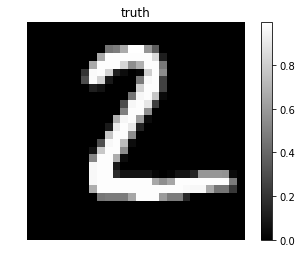

0.9489795918367347


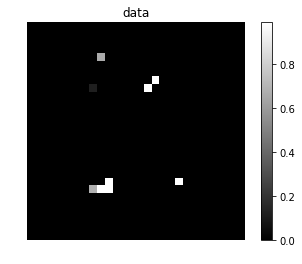

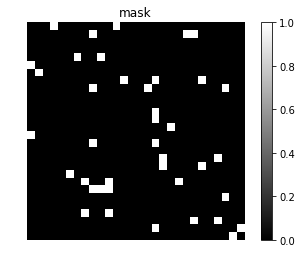

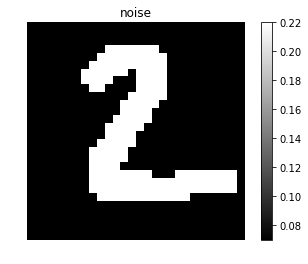

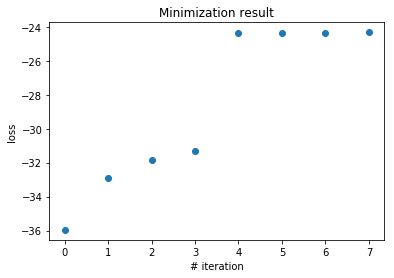

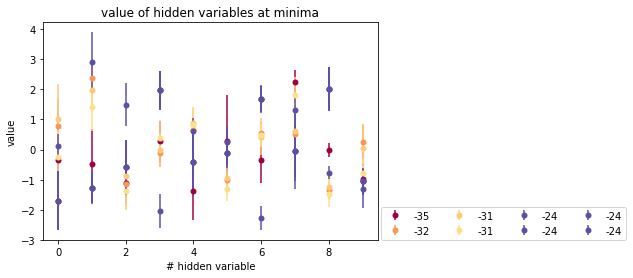

total chi2 of lowest minimum 23.0035378272049 on 40 pixels
chi2 of lowest minimum, low noise regions 7.601027263833162 on 31 pixels
chi2 of lowest minimum, high noise regions 15.40251056337174 on 9 pixels


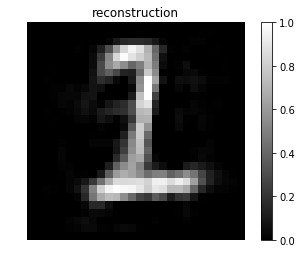

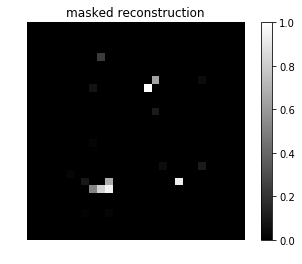

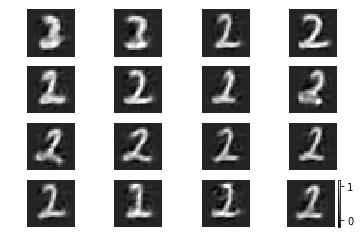

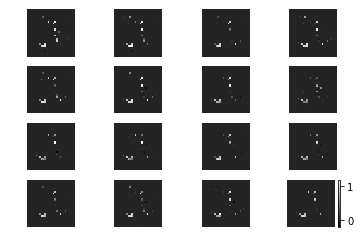

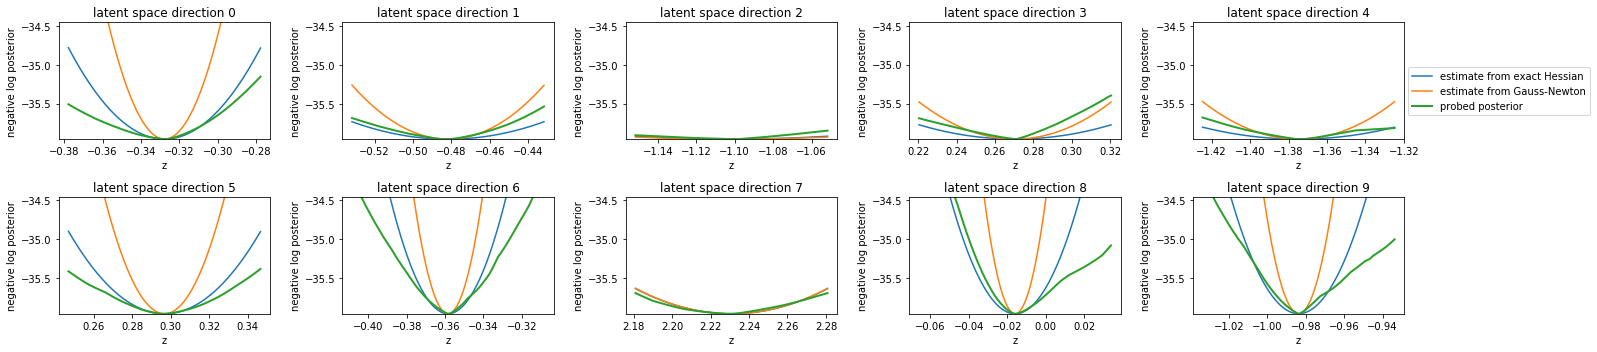

[-27.326881] [-35.955418]
[-24.861298] [-32.887863]
[array([-49.61886], dtype=float32), array([-45.318512], dtype=float32)]


In [36]:
if __name__ == "__main__":
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  
  
  truth = x_test[num_mnist:num_mnist+data_size]
  plot_image(truth, directory=plot_path, filename='truth_%s'%label, title='truth')
  
  data, custom_mask = make_corrupted_data(truth, corr_type=corr_type)
  plot_image(data, directory=plot_path, filename='input_data_%s'%label, title='data')
  plot_image(custom_mask, directory=plot_path, filename='mask_data_%s'%label, title='mask')
  
  noise = get_custom_noise(data.shape, signal_dependent=True, signal=truth)
  plot_image(noise, directory=plot_path, filename='noise_%s'%label, title='noise')
  
  
  tf.random.set_random_seed(seed)
  inits = get_random_start_values(20, sess)
  
  try:
    minima, min_loss, min_var, recons = pickle.load(open(minima_path+'minima_%s.pkl'%label,'rb'))
  except:
  
    minima  =[]
    min_loss=[]
    min_var =[]
    recons  =[]
    for jj,init in enumerate(inits):
      print('progress in %', jj/len(inits)*100)
      min_z, min_l, pos_def    = minimize_posterior(init, data,custom_mask,noise,sess)
      rec                      = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
      var                      = sess.run(variance, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
  
      plot_image(rec, directory=plot_path, filename='recon_%s_minimum%d'%(label,jj), title='reconstruction with loss %.1f'%min_l)
      print(min_z)
      if pos_def:
        print('hessian postive definite')
        minima.append(min_z)
        min_loss.append(min_l)
        min_var.append(var)
        recons.append(rec)
    
    order    = np.argsort(min_loss)
    min_loss = np.asarray(min_loss)[order]
    minima   = np.asarray(minima)[order]
    min_var  = np.asarray(min_var)[order]
    
    pickle.dump([minima, min_loss, min_var,recons],open(minima_path+'minima_%s.pkl'%label,'wb'))

  plot_minima(minima, min_loss, min_var)

  
  chi2s = get_chi2(noise,data,recons[0],masking=True, mask=custom_mask)
  
  
  print('total chi2 of lowest minimum', chi2s[0], 'on', chi2s[1] ,'pixels')
  print('chi2 of lowest minimum, low noise regions', chi2s[2], 'on', chi2s[3], 'pixels')
  print('chi2 of lowest minimum, high noise regions', chi2s[4], 'on', chi2s[5], 'pixels')
  
  lowest_minimum = sess.run(MAP_reset, feed_dict={MAP_ini:minima[0]})
  rec     = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
  plot_image(rec, directory=plot_path, filename='lowest_minimum_%s'%(label), title='reconstruction', vmin=0, vmax=1)
  plot_image(rec, directory=plot_path, filename='lowest_minimum_%s_masked'%(label), title='masked reconstruction', vmin=0, vmax=1, mask = custom_mask)
  samples = get_laplace_sample(16,minima[0],data,custom_mask,noise,sess)
  plot_samples(samples, custom_mask, title='samples', filename='samples')
  
  probe_posterior(minima[0], data, noise, custom_mask, sess)
  
  get_gmm_parameters(minima, data, noise, custom_mask)
  

In [0]:
def get_gmm_parameters(minima, x, noise, mymask):
  mu   =[]
  w    =[]
  sigma=[]
  offset=500
  for ii in range(num_comp):

    # do Laplace approximation around this minimum
    
    mu+=[minima[ii]]
    sess.run(MAP_reset,feed_dict={MAP_ini:minima[ii]})
    sigma+=[sess.run(update_TriL,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})]


    logdet  = sess.run(tf.linalg.logdet(approx_posterior_laplace.covariance()),feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    logprob = sess.run(nlPost_MAP,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    print(logdet,-logprob)
    w+=[0.5*logdet-logprob]
  print(w)
  mu     = np.reshape(np.asarray(mu),[1,num_comp,hidden_size])
  sigma  = np.reshape(np.asarray(sigma),[1,num_comp,hidden_size,hidden_size])
  w      = np.squeeze(np.asarray(w))
                         
  return mu, sigma, w
                                 

**get histogramms of reconstruction error of uncorrupted data**

In [0]:
num_iter = len(x_test)//batch_size
print(num_iter)
max_recon=0.
min_recon=1.
max_input=0.
min_input=1.
for ii in range(num_iter):
  x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
  rec       = sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)})
  max_recon = max(max_recon,max(rec.flatten()))
  min_recon = min(min_recon,min(rec.flatten()))

print(max_recon,min_recon)
print(max_input,min_input)

156
1.7157391 -0.6785018
0.0 1.0


In [269]:
num_iter = len(x_test)//batch_size
print(num_iter)
max_recon=0.
min_recon=1.
max_input=0.
min_input=1.
for ii in range(num_iter):
  x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
  rec       = sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)})
  max_recon = max(max_recon,max(rec.flatten()))
  min_recon = min(min_recon,min(rec.flatten()))

print(max_recon,min_recon)
print(max_input,min_input)


#bins_recon  = np.linspace(0.01,1.01,11.)
bins_recon  = np.linspace(0.02,max_recon+0.01,2)

for jj in range(len(bins_recon)+1):
  print(jj)
  ordered_inp = []
  ordered_rec = []
  full_rec    = []
  full_inp    = []
  for ii in range(num_iter):
    if ii%10==0:
      print(ii)
    x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
    rec       = np.squeeze(sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)}))
    indices   = numpy.digitize(rec,bins_recon)
    ordered_rec.append(rec[np.where(indices==jj)].flatten())
  
    ordered_inp.append(x_input[np.where(indices==jj)].flatten())
    
    full_inp.append(x_input.flatten())
    full_rec.append(rec.flatten())

  rec_bin =np.asarray([item for sublist in ordered_rec for item in sublist])
  inp_bin =np.asarray([item for sublist in ordered_inp for item in sublist])
    
#   plt.figure()
#   plt.title('input pixel values: %.2f <= x <= %.2f'%(bins_recon[jj],bins_recon[jj+1]))
#   _=plt.hist(rec_bin-inp_bin,bins=100,density=True)
#   plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
#   plt.savefig(plot_path+'input_bins_fine_binnum%d.png'%(jj+1),bbox_inches='tight',color='tomato')
#   plt.show()
  if jj is 0:
    plt.figure()
    plt.title('recon pixel values: x < %.2f'%(bins_recon[jj]))
    _=plt.hist(rec_bin-inp_bin,bins=100,density=True)
    plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
    plt.savefig(plot_path+'recon_bins_coarse_binnum%d.png'%(jj),bbox_inches='tight',color='tomato')
    plt.show()
  elif jj is len(bins_recon):
    plt.figure()
    plt.title('recon pixel values: x > %.2f'%(bins_recon[jj-1]))
    _=plt.hist(rec_bin-inp_bin,bins=100,density=True)
    plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
    plt.savefig(plot_path+'recon_bins_coarse_binnum%d.png'%(jj),bbox_inches='tight',color='tomato')
    plt.show()    
  else:   
    plt.figure()
    plt.title('recon pixel values: %.2f <= x < %.2f'%(bins_recon[jj-1],bins_recon[jj]))
    _=plt.hist(rec_bin-inp_bin,bins=100,density=True)
    plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
    plt.savefig(plot_path+'recon_bins_coarse_binnum%d.png'%(jj+1),bbox_inches='tight',color='tomato')
    plt.show()


NameError: ignored

0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
[0. 0. 0. ... 0. 0. 0.]
[ 1.3352823e-04 -8.1744147e-05 -8.4244493e-06 ...  1.4824371e-03
 -1.0297839e-05 -4.1344715e-04]
1
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
[0. 0. 0. ... 0. 0. 0.]
[0.02577235 0.03597046 0.04120356 ... 0.04950745 0.06720827 0.04670155]
2
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
[]
[]
[0.035516664, 0.19848852, nan]


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: ignored

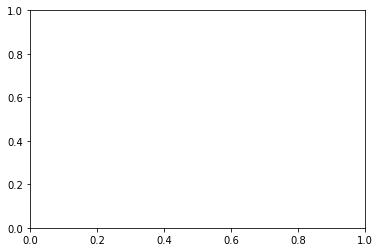

In [0]:
#bins_recon  = np.linspace(0.,1e-10,2)
L2s=[]

for jj in range(len(bins_recon)+1):
  print(jj)
  full_rec    = []
  full_inp    = []
  ordered_inp = []
  ordered_rec = []
  L2 = 0
  for ii in range(num_iter):
    
    if ii%10==0:
      print(ii)
    x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
    rec       = np.squeeze(sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)}))
    indices   = numpy.digitize(rec,bins_recon)

    ordered_rec.append(rec[np.where(indices==jj)].flatten())
  
    ordered_inp.append(x_input[np.where(indices==jj)].flatten())
    
    full_inp.append(x_input.flatten())
    full_rec.append(rec.flatten())

  rec_bin =np.asarray([item for sublist in ordered_rec for item in sublist])
  inp_bin =np.asarray([item for sublist in ordered_inp for item in sublist])
  print(inp_bin)
  print(rec_bin)
  L2=np.mean((rec_bin-inp_bin)**2)
  L2s.append(np.sqrt(L2))
  
print(L2s)
plt.figure()
plt.plot(np.diff(bins_recon)+bins_recon[0:-1],L2s,ls='',marker='o')
plt.xlabel('mean pixel values of reconstruction')
plt.ylabel('$\sqrt{E[(x_{recon}-x_{input})^2]}$', fontsize=14)
#plt.savefig(plot_path+'rms_difference_against_input_fine_bins.png',bbox_inches='tight')

plt.figure()
plt.plot(np.diff(bins_recon)+bins_recon[0:-1],L2s,ls='',marker='o')
plt.xlabel('mean pixel values of reconstruction')
plt.ylabel('$\sqrt{E[(x_{recon}-x_{input})^2]}$', fontsize=14)
#plt.savefig(plot_path+'rms_difference_against_input_fine_bins.png',bbox_inches='tight')

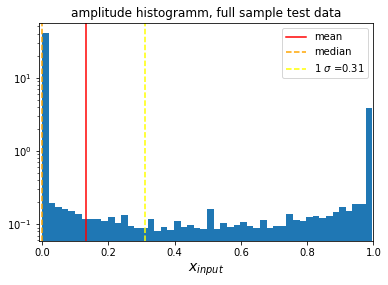

In [0]:
  diff=np.asarray(full_inp).flatten()
  plt.figure()
  plt.title('amplitude histogramm, full sample test data')
  _=plt.hist(diff,bins=50,density=True)
  plt.axvline(np.mean(diff),label='mean',color='red')
  plt.axvline(np.median(diff),label='median',color='orange',ls='--')
  plt.axvline(np.std(diff),label='1 $\sigma$ =%.2f'%np.std(diff),color='yellow',ls='--')
  plt.axvline(-np.std(diff),color='yellow',ls='--')
  plt.xlabel('$x_{input}$', fontsize=14)
  plt.xlim(-.01,1)
  plt.yscale('log')
  plt.legend()
  plt.savefig(plot_path+'input_histogramm.png',bbox_inches='tight')
  plt.show()

In [0]:
#   diff=np.asarray(full_rec).flatten()-np.asarray(full_inp).flatten()
#   plt.figure()
#   plt.title('full sample')
#   _=plt.hist(diff,bins=100,density=True)
#   plt.axvline(np.mean(diff),label='mean',color='red')
#   plt.axvline(np.median(diff),label='median',color='orange',ls='--')
#   plt.axvline(np.std(diff),label='1 $\sigma$ =%.2f'%np.std(diff),color='yellow',ls='--')
#   plt.axvline(-np.std(diff),color='yellow',ls='--')
#   plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
#   plt.xlim(-0.5,0.5)
#   plt.legend()
#   plt.savefig(plot_path+'full_sample_histogramm.png',bbox_inches='tight')
#   plt.show()

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

-0.6785022
(64, 784, 1)
(64, 784, 1)


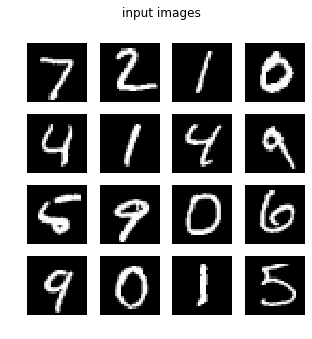

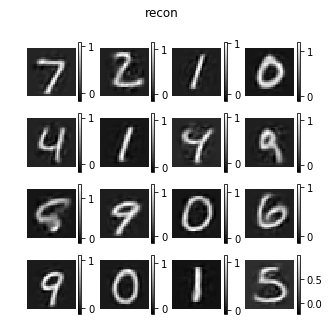

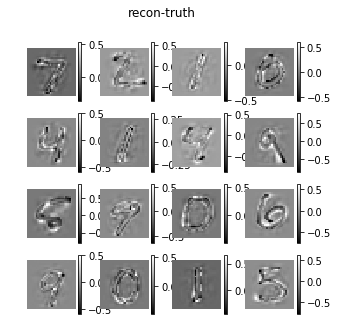

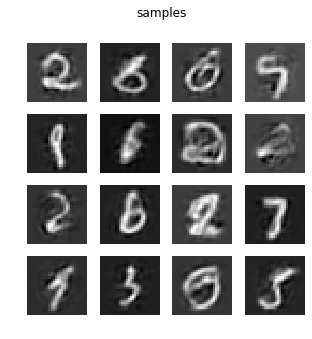

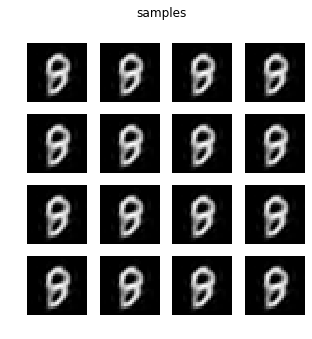

In [0]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
print(min(rec.flatten()))
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray'); colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('recon-truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0]-x_truth[i],(28,28)),cmap='gray'); colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray'); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
# nvp_loss = []
# ii     = 0
# nepoch = 0
# learning_rate = 1e-3

In [0]:
# #train the nvp
# while nepoch<1000:
#   if (ii+1)*batch_size>len(x_train): 
#     np.random.shuffle(x_train)
#     ii=0
#     nepoch+=1
#     print('starting epoch', nepoch)
#   if nepoch>10:
#     learning_rate=1e-5
#   if nepoch>200:
#     learning_rate=1e-6
#   x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
#   _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
#   nvp_loss+=[ll]
#   if ii%500==0:
#     print(ll)
#   ii+=1

In [0]:
# plt.figure()
# plot(nvp_loss[::],label='nvp loss')
# legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 23:15:28.626796 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


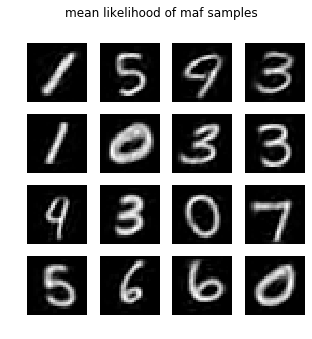

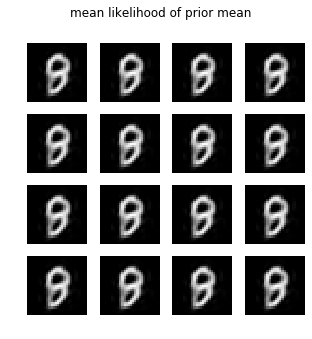

In [0]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [0]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 04:53:53.923635 139941427271552 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


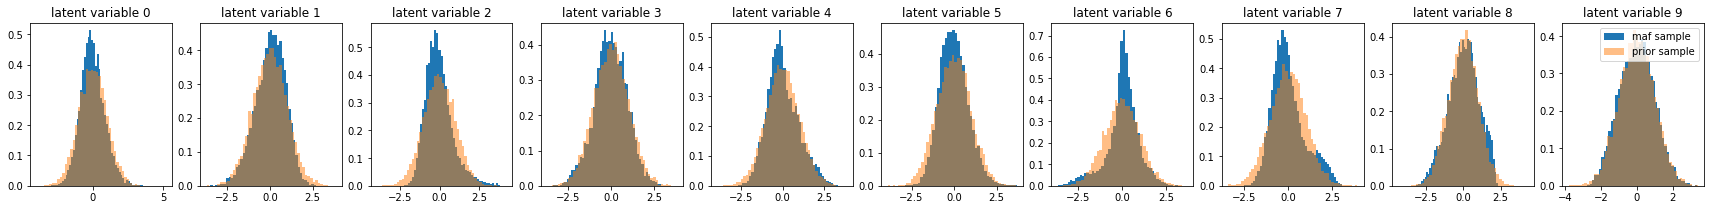

In [0]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

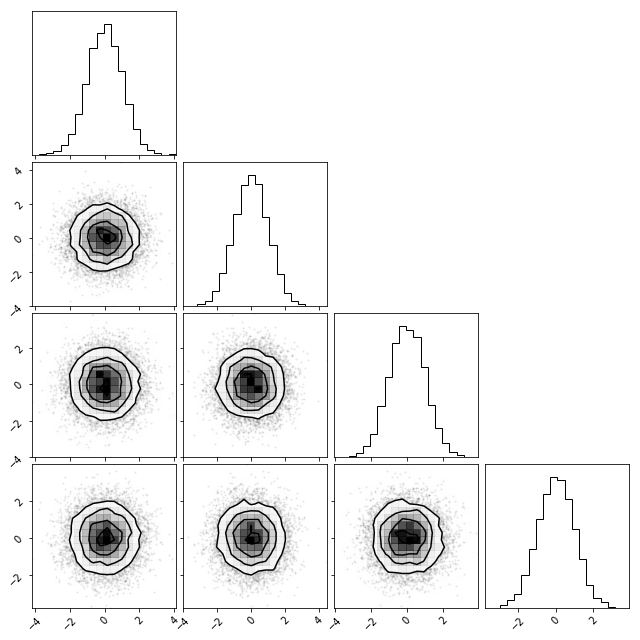

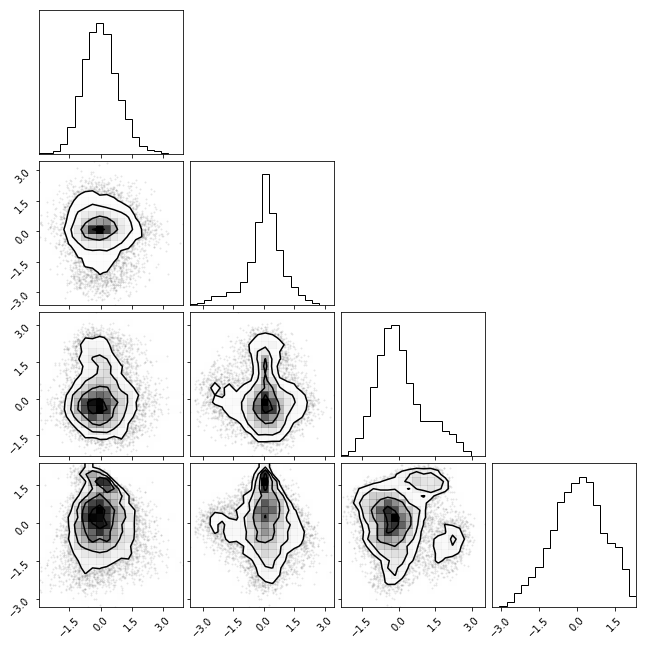

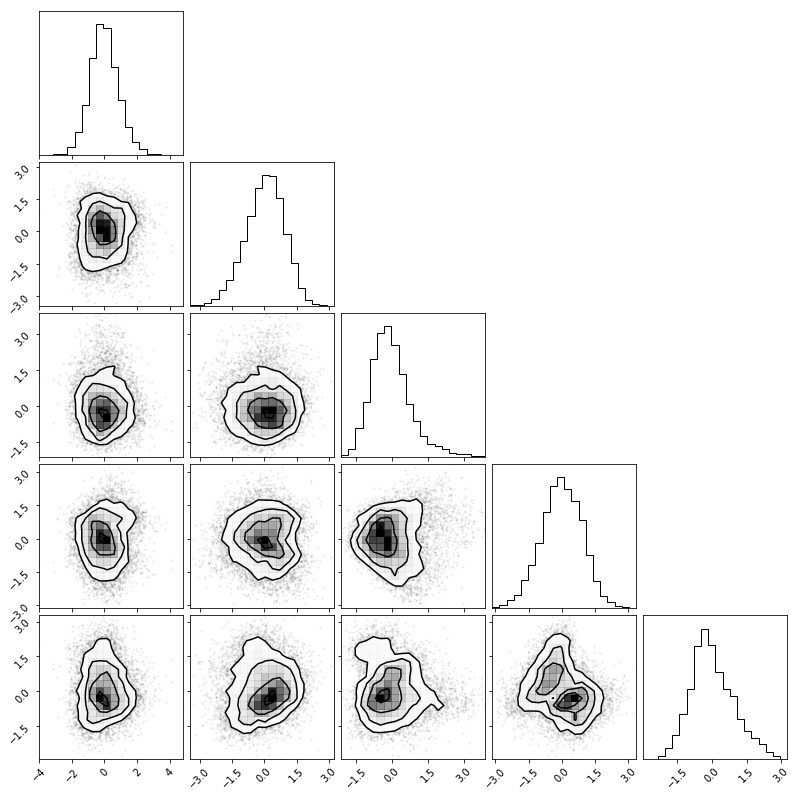

In [0]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])
_ = corner.corner(maf_s[:,0:5])

**Make corrupted data**

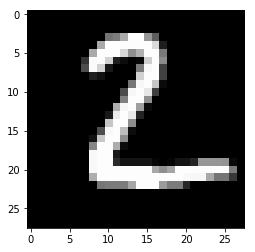

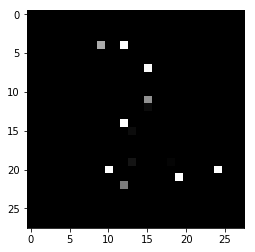

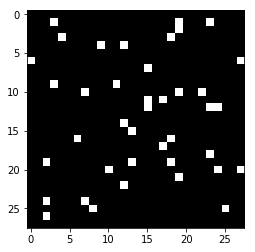

In [0]:
sigma_low = 0.07
sigma_high= 0.22
threshold = 0.02

mask = np.ones(data_dim, dtype=int)
percent = 95
np.random.seed(2)
indices = np.random.choice(np.arange(data_dim), replace=False,size=int(percent/100.*data_dim))
mask[indices] =0 

sigma_new = np.ones(mask.shape)


x_true      = x_test[1:1+batch_size2]
masked_data = x_true*[mask]
data        = np.expand_dims(masked_data,-1)


#signal dependent noise
sigma_new[np.where(x_true[0]<=threshold)]=sigma_low
sigma_new[np.where(x_true[0]>threshold)]=sigma_high


#should be masked anyways
#sigma_new[np.where(mask==0)] = 1e4
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)


plt.figure()
_=plt.imshow(x_true.reshape((28,28)),cmap='gray',vmin=0)
plt.show()

plt.figure()
_=plt.imshow(data.reshape((28,28)),cmap='gray',vmin=0)
plt.show()

plt.figure()
_=plt.imshow(mask.reshape((28,28)),cmap='gray',vmin=0)
plt.show()

(784,)

**find minima with nvp**

In [0]:
#generate starting values
mini_ini=[]
np.random.seed(28)
for ii in range(20):
  if ii ==1:
      mini_ini+=[np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))+1e-8]
  elif ii==0:
      mini_ini+=[sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})]
  else:
      mini_ini+=[np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))]

In [0]:
for ii in range(1):

  ini = mini_ini[ii]

  sess.run(MAP_reset,feed_dict={input_data:data , MAP_ini:ini})

#   lrate=1e-1
#   for jj in range(5000):
#     _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: })
#     posterior_corr_loss.append(ll)
#     if jj%1000==0:
#       print(ll)
#   lrate=1e-2
#   for jj in range(10000):
#     _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})
#     posterior_corr_loss.append(ll)
#     if jj%1000==0:
#       print(ll)
#   lrate=1e-3
#   print('switching to lr', lrate)
#   for jj in range(4000):
#     _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})
#     posterior_corr_loss.append(ll)
#     if jj%1000==0:
#       print(ll)
#   ev= sess.run(eig1,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})
#   print(ev)
  MAP_uncorrupted = sess.run([MAP],feed_dict={input_data: data})
    


In [0]:
sigma_new

array([[[0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        [0.07],
        

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 20:29:56.214882 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 20:29:57.074964 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 20:29:57.889455 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


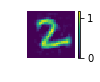

IndexError: ignored

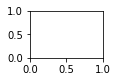

In [0]:
sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:MAP_uncorrupted[0],sigma_corr:sigma_new})
maploss       = sess.run(loss_MAP[0],feed_dict={input_data: np.expand_dims(x_true,-1), sigma_corr:sigma_new})

  #get mean without mask
mean_at_map = sess.run(get_likelihood(MAP)[1],feed_dict={input_data: np.expand_dims(x_true,-1), sigma_corr:sigma_new})
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean_at_map[i,:,0],(28,28)),vmin=0)
    plt.colorbar()
    axis('off')    
plt.show()
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(x_true[i,:,0],(28,28)),vmin=0)
    plt.colorbar()
    axis('off')    
plt.show()
chi2=np.sum((np.squeeze(x_true)[np.where(mask==1)]-np.squeeze(mean_at_map)[np.where(mask==1)])**2/np.squeeze(sigma_new)[np.where(mask==1)]**2)
print(maploss,chi2)


# sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:map_minima_pos_def[0][0], mymask:mask,sigma_corr:sigma_new})
# map_likeli, _ = sess.run(get_likelihood(MAP),feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})
# map_prior     = sess.run(prior.log_prob(MAP),feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})
# map_post      = sess.run(get_posterior(MAP),feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})
# maploss       = sess.run(loss_MAP[0],feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})

#   #get mean without mask
# mean_at_map = sess.run(get_likelihood(MAP)[1],feed_dict={input_data: data, sigma_corr:sigma_new})
# for i in range(min(batch_size2,16)):
#     subplot(4,4,i+1)
#     imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)))
#     plt.colorbar()
#     axis('off')    
# plt.show()
# chi2=np.sum((np.squeeze(data)[np.where(mask==1)]-np.squeeze(mean_at_map)[np.where(mask==1)])**2/np.squeeze(sigma_new)[np.where(mask==1)]**2)
# print(map_likeli,map_prior,map_post,maploss,chi2)

In [0]:
chi2=np.sum((np.squeeze(x_true)-np.squeeze(mean_at_map))**2/np.squeeze(sigma_new)**2)
print(chi2)

5813.310596179752


In [0]:
maps ={}
minima={}
pos_defs={}
final_losses={}

#for minimizer in ['lbfgs','lm','trf']:#,'annealing','adam']
l_minima            = []
map_minima          = []
pos_def             = []
for ii in range(10):
  posterior_corr_loss = []
  ini = mini_ini[ii]

  sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:ini, mymask:mask,sigma_corr:sigma_new})
  lrate=1e-1
  for jj in range(10000):
    if ii is not 0:
      inv_T= np.round(0.5*np.exp(-(1.-jj/10000)),decimals=1)
      
    else:
      inv_T=1
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new, lr: lrate, inverse_T:inv_T})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll, inv_T)
  lrate=1e-2
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for jj in range(4000):
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  ev= sess.run(eig1,feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new,true_hess:True})
  print(ev)
  if np.all(ev>0.):
    if ii is not 0:
      pos_def+=[ii]

  #plt.plot(posterior_corr_loss,label='data_loss')
  #plt.show()
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={input_data: data, sigma_corr:sigma_new})]
    
#   maps[minimizer]                = map_minima
#   final_losses[minimizer]        = l_minima
#   pos_defs[minimizer]            = pos_def


256.92816 1
-30.472239 1
-28.58468 1
13.417955 1
9.435164 1
9.422451 1
9.421347 1
9.432594 1
7.979233 1
8.352009 1
8.144602
7.7478495
7.7340527
7.774235
7.734622
7.7459097
7.771285
7.750272
7.7450705
7.747979
switching to lr 0.001
7.7522
7.7274914
7.729933
7.73001
[[ -1.9694384   -0.49947006   1.1736107    1.6553699    1.9519837
    3.8047557    6.3269563   46.79142     51.400246   198.52176   ]]
74.59057 0.2
14.988052 0.2
14.990837 0.2
14.993129 0.2
16.796562 0.3
16.800781 0.3
16.797523 0.3
61.74926 0.4
61.71441 0.4
68.726845 0.5
93.93184
91.33433
91.30931
91.305466
91.36609
91.3143
91.309525
91.34413
91.34449
91.311264
switching to lr 0.001
91.29588
91.27933
91.2796
91.280655
[[ -1.5437988   0.7885244   1.0033193   1.0148838   1.1060156   1.3683931
    3.7245202  19.438     471.0311    712.74567  ]]
66.04875 0.2
18.100487 0.2
17.953108 0.2
17.92829 0.2
18.113634 0.3
18.339819 0.3
18.441542 0.3
18.326178 0.4
18.441622 0.4
18.928947 0.5
19.399218
18.597755
18.592411
18.647694
18.626106

In [0]:
print(pos_def)

[4, 5, 6, 8, 9]


In [0]:
import copy

l_minima_corrected=[]
map_minima_corrected=[]

for ii in range(len(map_minima_pos_def)):
  posterior_corr_loss = []
  ini = map_minima_pos_def[ii]
  
  sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:ini[0], mymask:mask,sigma_corr:sigma_new})
  mean_at_map = sess.run(get_likelihood(MAP)[1],feed_dict={input_data: data, sigma_corr:sigma_new})
  sigma_fit = copy.deepcopy(sigma_new)
  sigma_fit[np.where(mean_at_map<threshold*2)]=sigma_low*2
  sigma_fit[np.where(mean_at_map<threshold)]=sigma_low
  lrate=1e-2
  print('switching to lr', lrate)
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_fit, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for jj in range(4000):
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_fit, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  ev= sess.run(eig1,feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_fit,true_hess:True})
  print(ev)
  if np.all(ev>0.):
    if ii is not 0:
      pos_def+=[ii]

  #plt.plot(posterior_corr_loss,label='data_loss')
  #plt.show()
  l_minima_corrected+=[ll]
  map_minima_corrected+=[sess.run([MAP],feed_dict={input_data: data, sigma_corr:sigma_new})]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 16:33:35.966082 140129836439424 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 16:33:36.517806 140129836439424 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 16:33:37.013069 140129836439424 saver.py:1483] Saver not created because there are no variables in the graph to restore


switching to lr 0.01
-580.0886
-580.15106
-580.1632
-580.13025
-580.15735
-580.11017
-580.1697
-580.175
-580.1671
-580.16296
switching to lr 0.001
-580.1748
-580.1816
-580.1809
-580.1743
[[9.6957982e-01 2.4847150e+00 4.2043905e+00 9.5791121e+00 1.7698439e+01
  3.0164810e+01 6.9828812e+01 3.8351776e+02 3.0350103e+03 2.5618246e+04]]
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 16:34:49.554690 140129836439424 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 16:34:50.112326 140129836439424 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 16:34:50.632225 140129836439424 saver.py:1483] Saver not created because there are no variables in the graph to restore


switching to lr 0.01
-582.6991
-582.7165
-582.71
-582.7101
-582.7046
-582.7062
-582.7085
-582.7071
-582.6877
-582.70886
switching to lr 0.001
-582.7075
-582.7105


In [0]:
print(pos_def)

[1, 2, 3, 5, 6, 8, 9]


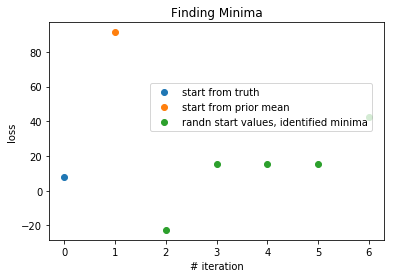

In [0]:
# print(pos_def)
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)

order = np.argsort(l_minima[pos_def])
l_minima_pos_def   = l_minima[pos_def][order]
map_minima_pos_def = map_minima[pos_def][order]
plt.figure()
plt.title('Finding Minima')
plt.plot(0,l_minima[0],ls='',marker='o',label='start from truth')
plt.plot(1,l_minima[1],ls='',marker='o',label='start from prior mean')
plt.plot(np.arange(len(map_minima_pos_def))+2,l_minima_pos_def,ls='',marker='o', label='randn start values, identified minima')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.legend(loc=(0.3,0.5))
plt.savefig(plot_path+'minimzation_results_sparse_mask%d_and_new_sigmas.png'%(percent),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  l_minima,map_minima,l_minima_pos_def,map_minima_pos_def = pickle.load(open(minima_path+'nvp_minima_sparse_mask%d_and_new_sigmas.pkl'%(percent),'rb'))
except:
  pickle.dump([l_minima,map_minima,l_minima_pos_def,map_minima_pos_def],open(minima_path+'nvp_minima_sparse_mask%d_and_new_sigmas.pkl'%percent,'wb'))
  
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)

In [0]:
print(len(np.where(mask==1)[0])), 0.05*28*28

40


(None, 39.2)

In [0]:
print(l_minima_pos_def[0])
_ = sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:map_minima_pos_def[0][0], sigma_corr:sigma_new})
  #get mean without mask
mean_at_map = sess.run(get_likelihood(MAP)[1],feed_dict={input_data: data, sigma_corr:sigma_new})
np.sum((np.squeeze(data)[np.where(mask==1)]-np.squeeze(mean_at_map)[np.where(mask==1)])**2/np.squeeze(sigma_new)[np.where(mask==1)]**2)

-22.56209
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:30:39.424097 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:30:39.961142 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:30:40.438824 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


39.38425358192721

In [0]:
print(np.sum((np.squeeze(data)[np.where(x_true[0]>0.02)]-np.squeeze(mean_at_map)[np.where(x_true[0]>0.02)])**2/np.squeeze(sigma_new)[np.where(x_true[0]>0.02)]**2))
print(len(np.where(x_true[0][np.where(mask==1)]>0.02)[0]))

36.239550915927964
12


In [0]:
print(np.sum((np.squeeze(data)[np.where(x_true[0]<=0.02)]-np.squeeze(mean_at_map)[np.where(x_true[0]<=0.02)])**2/np.squeeze(sigma_new)[np.where(x_true[0]<=0.02)]**2))
print(len(np.where(x_true[0][np.where(mask==1)]<=0.02)[0]))

3.144703232567273
28


**get covariances around minima**

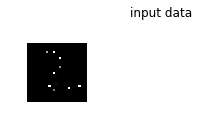

result 0
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:13:33.019874 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:13:33.768779 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:13:34.406327 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:13:42.853432 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:13:43.632493 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:13:44.334845 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


[10.316488] [-18.046711]


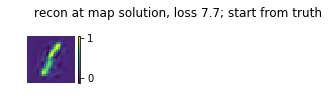

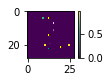

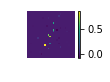

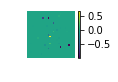

covariances


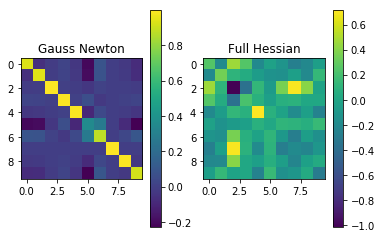

hessians


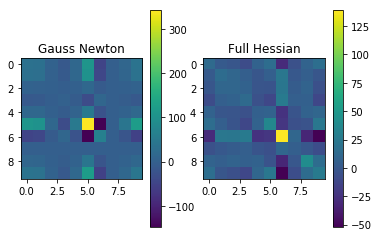

eigenvalues before and after inverse, full hessian
[array([[ -1.9694384 ,  -0.49947006,   1.1736107 ,   1.6553699 ,
          1.9519837 ,   3.8047557 ,   6.3269563 ,  46.79142   ,
         51.400246  , 198.52176   ]], dtype=float32), array([[-2.00209891, -0.50776084,  0.00503723,  0.01945516,  0.02137144,
         0.15805393,  0.26282861,  0.51230121,  0.60409239,  0.85207111]])]
result 1
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:14:16.706061 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:14:17.602790 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:14:18.514356 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:14:29.755290 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:14:30.718392 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:14:31.583896 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


[36.179146] [-13.616945]


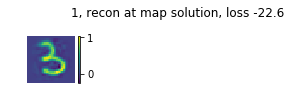

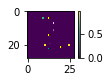

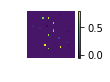

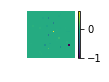

covariances


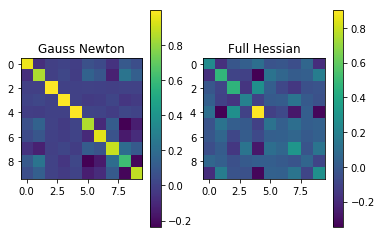

hessians


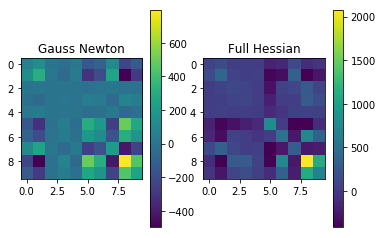

eigenvalues before and after inverse, full hessian
[array([[6.6829282e-01, 1.5575387e+00, 2.7619607e+00, 3.8265755e+00,
        4.4820995e+00, 1.0254366e+01, 5.6255875e+01, 2.6453467e+02,
        1.5678657e+03, 3.2507017e+03]], dtype=float32), array([[3.07625851e-04, 6.37809612e-04, 3.78022342e-03, 1.77759078e-02,
        9.75200696e-02, 2.23109662e-01, 2.61332974e-01, 3.62070781e-01,
        6.42010804e-01, 1.49640423e+00]])]


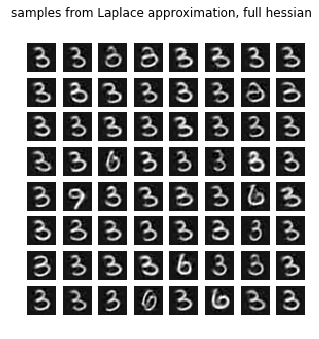

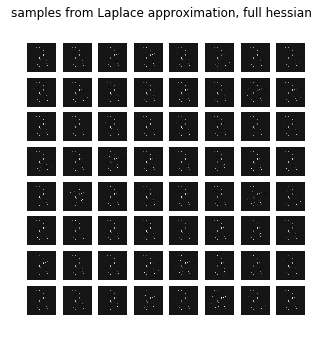

result 2
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:15:23.276364 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:15:24.082332 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:15:24.874489 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:15:34.764259 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:15:35.561383 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 17:15:36.279981 140655776503680 saver.py:1483] Saver not created because there are no variables in the graph to restore


[-3.258121] [-12.256384]


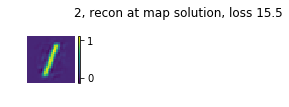

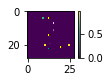

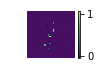

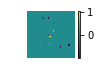

covariances


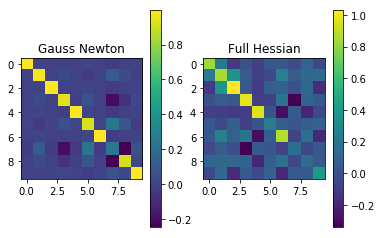

hessians


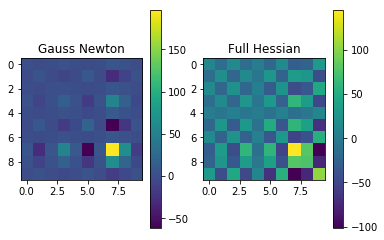

eigenvalues before and after inverse, full hessian
[array([[  0.5910514 ,   0.86099446,   0.99226046,   1.1121277 ,
          1.4252576 ,   1.6536922 ,   2.843986  ,  25.002567  ,
         40.73797   , 411.17038   ]], dtype=float32), array([[0.00243208, 0.02454713, 0.03999586, 0.35162076, 0.60470909,
        0.70163124, 0.89917821, 1.00779661, 1.16145104, 1.69189088]])]


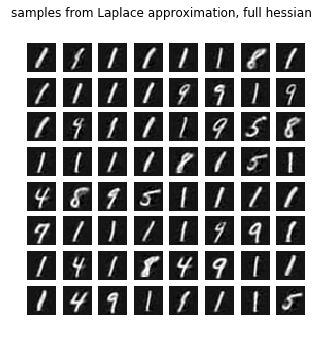

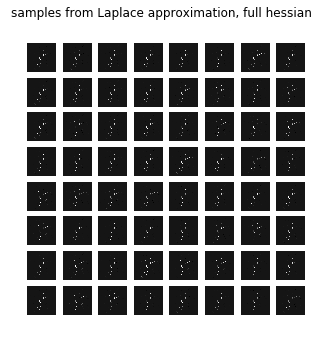

In [0]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis = [] 
chi2_mean =[]
chi2_samples=[]
chi2_samples_low=[]
chi2_samples_high=[]

order      = np.argsort(l_minima_pos_def)
results    = np.concatenate((np.expand_dims(map_minima[0],0),map_minima_pos_def[order]), axis=0)
l_results  = np.concatenate((np.expand_dims(l_minima[0],0),l_minima_pos_def[order]), axis=0)

# go through minima
for ii,ini_ in enumerate(results[0:3]):
  print('result %d'%ii)
  
  _ = sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  #get mean without mask
  mean_at_map = sess.run(get_likelihood(MAP)[1],feed_dict={input_data: data, sigma_corr:sigma_new})
  
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={input_data: data, sigma_corr:sigma_new,mymask:mask, MAP_ini:ini_[0]})
  
  map_likeli, _ = sess.run(get_likelihood(MAP),feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})
  map_prior     = sess.run(prior.log_prob(MAP),feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})
  print(map_likeli,map_prior)
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_results[ii])
  else:
    suptitle('%d, recon at map solution, loss %.1f'%(ii,l_results[ii]))
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)))
      plt.colorbar()
      axis('off')
  plt.show()
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(data[i,:],(28,28)))
      plt.colorbar()
  plt.show()
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)))
      plt.colorbar()
      axis('off')    
  plt.show()
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape((mean_at_map[i,:,0]-data[0,:,0])*mask,(28,28)))
      plt.colorbar()
      axis('off')
  plt.show()

#   # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True})]
  

  
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True})
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True})
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True}))
  try:
    _ = sess.run(update3,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True})
    l_samples = sess.run(lap_mean,feed_dict={input_data: data, sigma_corr:sigma_new, true_hess:True})
    chi2_mean.append(np.sum((np.squeeze(data)[np.where(mask==1)]-np.squeeze(mean_at_map)[np.where(mask==1)])**2/np.squeeze(sigma_new)[np.where(mask==1)]**2))
    chi2_low=[]
    chi2_high=[]
    chi2_s=[]
    for nn in range(len(l_samples)):

      chi2_s.append(np.sum((np.squeeze(data)[np.where(mask==1)]-np.squeeze(l_samples[nn])[np.where(mask==1)])**2/np.squeeze(sigma_new)[np.where(mask==1)]**2))
      chi2_low.append(np.sum((np.squeeze(data)[x_true[0]<=0.02]-np.squeeze(l_samples[nn])[x_true[0]<=0.02])**2/np.squeeze(sigma_new)[x_true[0]<=0.02]**2))
      chi2_high.append(np.sum((np.squeeze(data)[x_true[0]>0.02]-np.squeeze(l_samples[nn])[x_true[0]>0.02])**2/np.squeeze(sigma_new)[x_true[0]>0.02]**2))
    chi2_samples_low.append(chi2_low)
    chi2_samples_high.append(chi2_high)
    chi2_samples.append(chi2_s)

    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=-0.1,vmax=1.1)
        axis('off')
    plt.show()
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0]*mask,(28,28)),cmap='gray',vmin=-0.1,vmax=1.1)
        axis('off')
    plt.show()
  except:
    pass

NameError: ignored

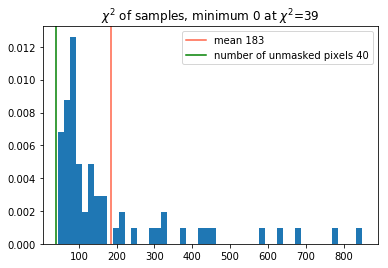

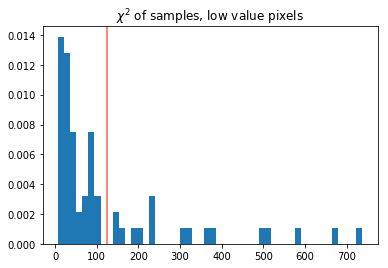

In [0]:
for ii in range(len(chi2_mean)):
  low=chi2_samples_low[ii]
  high=chi2_samples_high[ii]
  tot=chi2_samples[ii]
  
  plt.figure()
  plt.title('$\chi^2$ of samples, minimum %d at $\chi^2$=%d'%(ii,chi2_mean[ii]))
  plt.hist(tot, bins=50,density=True)
  plt.axvline(x=np.mean(tot),label='mean %d'%np.mean(tot), c='tomato')
  num = len(np.where(mask==1)[0])
  plt.axvline(x=num,label='number of unmasked pixels %d'%num, c='green')
  plt.legend()
  #plt.savefig(plot_path+'chi2_hist_samples_min%d.png'%ii,bbox_inches='tight')
  
  plt.figure()
  plt.title('$\chi^2$ of samples, low value pixels')
  plt.hist(low, bins=50,density=True)
  plt.axvline(x=np.mean(low),label='mean %d'%np.mean(tot), c='tomato')
  num = len(np.where(x_truth[0][np.where(mask==1)]<threshold)[0])
  plt.axvline(x=num,label='number of unmasked pixels %d'%num, c='green')
  plt.legend()
  #plt.savefig(plot_path+'chi2_hist_samples_low_min%d.png'%ii,bbox_inches='tight')
  
  
  plt.figure()
  plt.title('$\chi^2$ of samples, high value pixels')
  plt.hist(high, bins=50,density=True)
  plt.axvline(x=np.mean(high),label='mean %d'%np.mean(tot), c='tomato')
  num = len(np.where(x_truth[0][np.where(mask==1)]>threshold)[0])
  plt.axvline(x=num,label='number of unmasked pixels %d'%num, c='green')
  plt.legend()
  #plt.savefig(plot_path+'chi2_hist_samples_high_min%d.png'%ii,bbox_inches='tight')

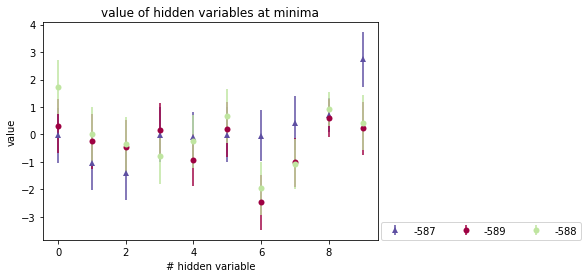

In [0]:
# check if minima are distinct
order              = np.argsort(l_minima_pos_def)
map_minima_pos_def = np.asarray(map_minima_pos_def[order])
l_minima_pos_def   = np.asarray(l_minima_pos_def[order])
varis              = np.asarray(varis)

colors = matplotlib.colors.Normalize(vmin=min(l_results[0:3]), vmax=max(l_results[0:3]))
cmap   = matplotlib.cm.get_cmap('Spectral')

plt.title('value of hidden variables at minima')
for ii in range(len(results)-5):
  yerr_= np.sqrt(varis[ii,0])
  if ii ==0:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='^',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
  else:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='o',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.savefig(plot_path+'minima_sparse_mask%d_and_new_sigmas.png'%(percent),bbox_inches='tight')
plt.show()


# plt.title('value of hidden variables at minima')
# for ii in range(len(results[0:3])):
#   yerr_= np.sqrt(varis[ii,0])
#   if ii ==0:
#     plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='^',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
#   else:
#     plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='o',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
# plt.legend(ncol=4, loc=(1.01,0))
# plt.xlabel('# hidden variable')
# plt.ylabel('value')
# plt.savefig(plot_path+'minima_xmin%d_xmax%d_only_two.png'%(minx,maxx),bbox_inches='tight')
# plt.show()

**explore posterior around minima**

[[[ 0.30157056 -0.25725162 -0.46559805  0.16115157 -0.93112975
    0.18002118 -2.4809823  -1.0089093   0.5968026   0.22005923]]] -589.29346


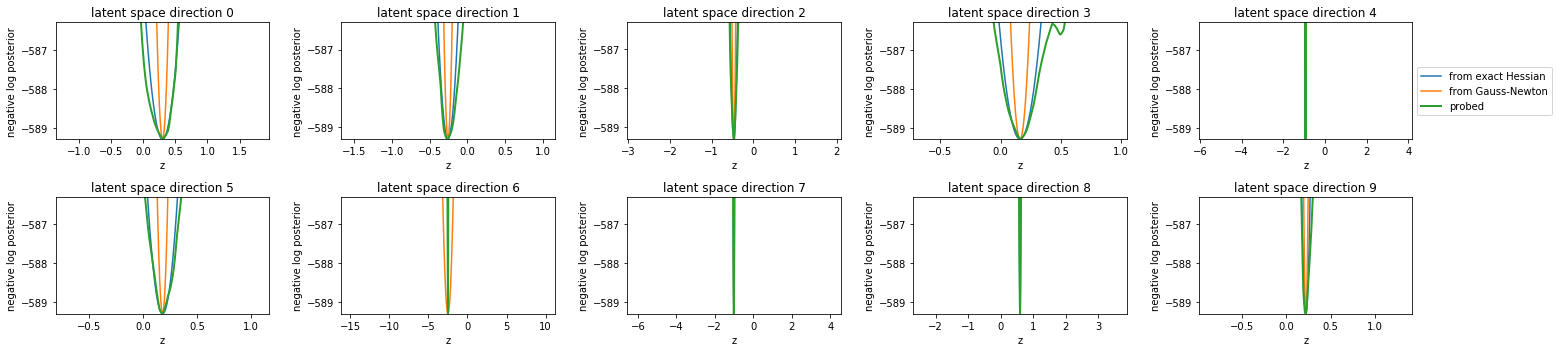

[[[ 1.7251042   0.0068636  -0.36372107 -0.79944927 -0.24793486
    0.6583278  -1.9627826  -1.0776503   0.9193531   0.42348152]]] -588.2544


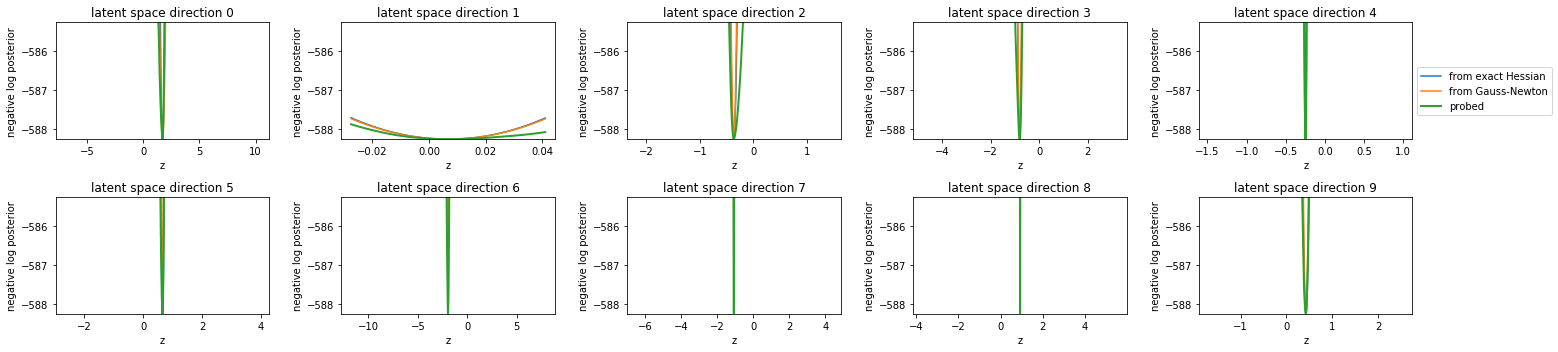

In [0]:
order     = np.argsort(l_minima_pos_def)[0:2]

# testing Hessian
for ii,ini_ in enumerate(map_minima_pos_def[order]):
  print(ini_, l_minima_pos_def[order][ii])
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:False})
  ll0 = sess.run(loss_MAP[0],feed_dict={input_data: data,mymask:mask, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B    = measured_hessian[0,nn,nn]
    GN   = GN_hessian[0,nn,nn]
#     VIm  = np.linalg.inv(VI_cov)[0,nn,nn]

#     z_VI  = (0.001*(np.arange(1001)-501))*VI_mean[0,nn]
    
#     VImf  = np.linalg.inv(VI_f_cov)[0,nn,nn]

#     z_VIf = (0.001*(np.arange(1001)-501))*VI_f_mean[0,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(1001):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-501))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={input_data: data,mymask:mask, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(loss_MAP[0],feed_dict={input_data: data,mymask:mask, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(ll)
     

    

    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(1001)-501))*ini_[0][:,nn],ll0+B*((0.01*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from exact Hessian')
    #plt.plot(z_VI+VI_mean[0,nn],-ll0+VIm*z_VI**2,label='from mean field VI', color='tomato')
    #plt.plot(z_VIf+VI_f_mean[0,nn],-ll0+VImf*z_VIf**2,label='from full rank VI', color='darkblue')
    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(1001)-501))*ini_[0][:,nn],ll0+GN*((0.01*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    #print(losses)
    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(1001)-501))*ini_[0][:,nn],losses,label='probed', lw=2)
    
    
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.ylim(min(losses),min(losses)+3)
#     if nn in [0,1]:
#    plt.xlim(ini_[0][:,nn]-0.02, ini_[0][:,nn]+0.02)
#     elif nn in [2,3,4,5,6,9]:
#       plt.xlim(ini_[0][:,nn]-0.1, ini_[0][:,nn]+0.1)
#     elif nn in [7,8]:
#       plt.xlim(ini_[0][:,nn]-0.05, ini_[0][:,nn]+0.05)
  plt.tight_layout()
  plt.legend(loc=(1.02,1.7))
  
  
  
  plt.savefig(plot_path+'probing_posterior_sparse_mask_newlikelihood_loss%d_zoomout.png'%(percent,-ll0),bbox_inches='tight')
  plt.show()


**Build Gaussian Mixture Model**

In [0]:
mu_     =[]
sigma_  =[]
w_tilde =[]
#diag    =[]

offset_ = min(l_results) #for numerical stability
order   = np.append(np.argsort(l_minima_pos_def)[0],np.argsort(l_minima_pos_def)[1])#np.argsort(l_minima_pos_def)
mus     = map_minima_pos_def[order]

# loop over components, start with lowest, go higher and higher
for ii in range(num_comp):
  
  # do Laplace approximation around this minimum
  sess.run(MAP_reset,feed_dict={input_data: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})
  mu_+=[sess.run(update2,feed_dict={input_data: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})]
  sigma_+=[sess.run(update3,feed_dict={input_data: data, sigma_corr:sigma_new,MAP_ini:mus[ii][0],true_hess:True})]
  

  logdet_ = sess.run(log_det,feed_dict={input_data: data, sigma_corr:sigma_new,true_hess:True})
  logprob = sess.run(posterior_MAP,feed_dict={input_data: data, sigma_corr:sigma_new})
  print(logprob)
  w_tilde+=[np.exp(0.5*logdet_+logprob+offset_)]

mu_    = np.reshape(np.asarray(mu_),[1,num_comp,hidden_size])
sigma_ = np.reshape(np.asarray(sigma_),[1,num_comp,hidden_size,hidden_size])

w_tilde= np.squeeze(np.asarray(w_tilde))


#before =sess.run(sigma_gmmt,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde })
_=sess.run(update_a,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
_=sess.run(update_b,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
_=sess.run(update_c,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
_=sess.run(update_d,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })

ws= sess.run(w_rescaled,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
print(ws,np.sum(ws))
cc, qq, pp = sess.run([c_gmm, gmm.log_prob(mus[-1]),posterior_MAP],feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
print('this should be zero:', cc-qq+pp)

[-2610.098]
[-2614.1653]
[0.9949962  0.00500302] 0.9999992
this should be zero: [[0.]]


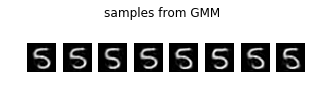

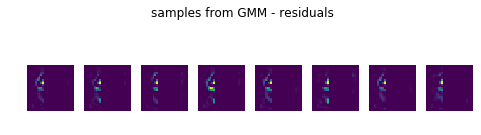

18.280572964497583


In [0]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={input_data: data, sigma_corr:sigma_new, offset:offset_})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d_annealing.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d_annealing.png'%(minx,maxx),bbox_inches='tight')
plt.show()

print(np.sum((gmm_samples[:,:,0]*mask-data[0,:,0]*mask)**2))

In [0]:
losses=[]

In [0]:
weight_=0.
for ii in range(1000):
  _, ll, mm, ww, cc, pp, gg, diff = sess.run([opt_op_el2o_red,el2o_red, mu_gmm,w_rescaled, c_gmm, posterior_gmm,posterior_z, abs_diff],feed_dict={input_data: data, sigma_corr:sigma_new, lr:1e-3, offset:offset_})
  losses.append(ll)
  if ii%200==0:
    print(ll,ww,sum(ww),cc,np.mean(pp), np.mean(gg), np.mean(diff))

6560.918 [0.9984563  0.00154455] 1.0000008 2624.7761 -9.272356 2629.4438 -13.940247
2877.9128 [0.99847347 0.00152585] 0.99999934 2625.2754 -10.896157 2625.5977 -11.218567
1611.0448 [9.9933654e-01 6.6433073e-04] 1.0000008 2625.7976 -9.672686 2626.9287 -10.803955
3584.5308 [9.995881e-01 4.128087e-04] 1.0000008 2626.233 -9.167431 2624.0593 -6.993805
1211.3887 [9.9962234e-01 3.7815617e-04] 1.0000005 2626.6116 -10.266684 2621.109 -4.7640076


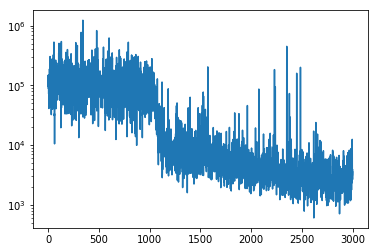

In [0]:
plt.plot(losses)
plt.yscale('log')

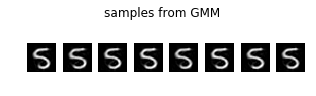

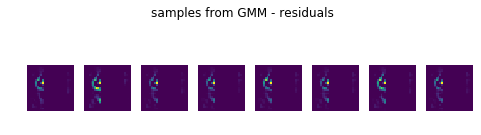

13.229199499620915


In [0]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={input_data: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

print(np.sum((gmm_samples[:,:,0]*mask-data[0,:,0]*mask)**2))

In [0]:
losses2=[]

In [0]:
weight_=1
for ii in range(20):
  _, ll, mm, ww, cc, pp, gg, diff = sess.run([opt_op_el2o,el2o, mu_gmm,w_rescaled, c_gmm, posterior_gmm,posterior_z, abs_diff],feed_dict={input_data: data, sigma_corr:sigma_new, lr:1e-4, offset:offset_, weight:weight_})
  losses2.append(ll)
  if ii%1==0:
    print(ll,ww,sum(ww),cc,np.mean(pp), np.mean(gg), np.mean(diff))

2461610.5 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.823833 2619.0522 -2.4927979
4555448.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.97097 2624.3774 -7.9654236
3073071.8 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.041865 2622.8198 -5.4785156
2463527.2 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.558861 2621.8657 -5.041626
3312580.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -12.321661 2620.3154 -5.2538757
3679113.8 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -9.863888 2619.5017 -1.982605
2329587.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.721672 2622.0488 -5.3873596
3539965.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -9.561429 2624.8755 -7.0538635
2521842.2 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -9.931238 2623.4387 -5.9868774
6635239.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.024919 2617.9363 -0.57818604
3825683.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.94418 2623.438 -6.999176
2541821

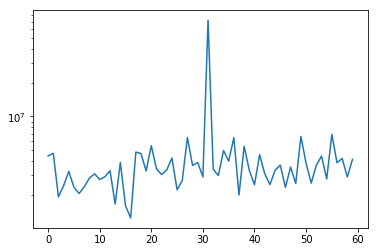

In [0]:
plt.plot(losses2)
plt.yscale('log')

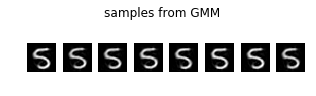

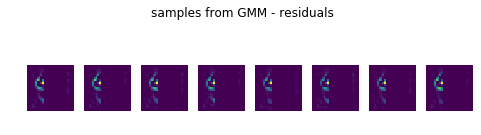

12.743787475849027


In [0]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={input_data: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

print(np.sum((gmm_samples[:,:,0]*mask-data[0,:,0]*mask)**2))